# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objetivo es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

Importamos las librerias necesarias

In [ ]:
import re
import numpy as np
import os
import gdown
import json
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras import layers, models, utils
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding

In [ ]:
# Descargamos la carpeta de dataset
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 70.2MB/s]


In [ ]:
# dataset_file
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [ ]:
# Observamos los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [ ]:
chat_in = []
chat_out = []

input_sentences = [] # oraciones de entrada
output_sentences = [] # oraciones de salida
output_sentences_inputs = [] # oraciones de salida con <sos>
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [ ]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [ ]:
# Inicializamos el Tokenizer para las entradas
tokenizer_inputs = Tokenizer()
tokenizer_inputs.fit_on_texts(input_sentences)

In [ ]:
# Convertimos las frases de entrada a secuencias de enteros
encoder_input_sequences = tokenizer_inputs.texts_to_sequences(input_sentences)

In [ ]:
# Calculamos el largo máximo de las secuencias de entrada
max_input_len = max([len(seq) for seq in encoder_input_sequences])

In [ ]:
# Creamos el diccionario de palabras a índices para las entradas
word2idx_inputs = tokenizer_inputs.word_index
print('Tamaño del vocabulario de entrada:', len(word2idx_inputs))

Tamaño del vocabulario de entrada: 1799


In [ ]:
# Inicializamos el Tokenizer para las salidas
tokenizer_outputs = Tokenizer()
tokenizer_outputs.fit_on_texts(output_sentences + output_sentences_inputs)

In [ ]:
# Convertimos las frases de salida a secuencias de enteros
decoder_output_sequences = tokenizer_outputs.texts_to_sequences(output_sentences)
decoder_input_sequences = tokenizer_outputs.texts_to_sequences(output_sentences_inputs)

In [ ]:
# Calculamos el largo máximo de las secuencias de salida
max_out_len = max([len(seq) for seq in decoder_output_sequences])

In [ ]:
# Creamos el diccionario de palabras a índices para las salidas
word2idx_outputs = tokenizer_outputs.word_index

# Asegúrate de incluir '<sos>' y '<eos>' en el vocabulario de salida
word2idx_outputs['<sos>'] = len(word2idx_outputs) + 1
word2idx_outputs['<eos>'] = len(word2idx_outputs) + 1

# Imprimimos el tamaño del vocabulario de salida
print('Tamaño del vocabulario de salida:', len(word2idx_outputs))

# Imprimimos una muestra del diccionario
print({k: word2idx_outputs[k] for k in list(word2idx_outputs)[:10]})

Tamaño del vocabulario de salida: 1808
{'eos': 1, 'sos': 2, 'you': 3, 'i': 4, 'do': 5, 'what': 6, 'a': 7, 'are': 8, 'to': 9, 'for': 10}


In [ ]:
print(f"<sos>: {word2idx_outputs.get('<sos>')}, <eos>: {word2idx_outputs.get('<eos>')}")

<sos>: 1807, <eos>: 1808


In [ ]:
# Calculamos el número de palabras en el vocabulario de salida
num_words_output = len(word2idx_outputs) + 1  # +1 por el padding o out-of-vocabulary
print('Número de palabras en el vocabulario de salida:', num_words_output)

Número de palabras en el vocabulario de salida: 1809


In [ ]:
# Visualizamos los largos máximos
print(f"Largo máximo de las secuencias de entrada: {max_input_len}")
print(f"Largo máximo de las secuencias de salida: {max_out_len}")

Largo máximo de las secuencias de entrada: 9
Largo máximo de las secuencias de salida: 10


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [ ]:
# Descargamos el embeddings Glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
# Cargamos los embeddings preentrenados de Glove
# Ruta a los embeddings de GloVe (100 dimensiones)
glove_file = 'glove.6B.100d.txt'

# Cargamos los embeddings preentrenados en un diccionario
embeddings_index = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Se cargaron {len(embeddings_index)} embeddings preentrenados.")

Se cargaron 400000 embeddings preentrenados.


Creamos la matriz embedding

In [ ]:
# Dimensión de los embeddings (100 en este caso)
embedding_dim = 100
# Número total de palabras en el vocabulario de entrada
num_words_input = len(word2idx_inputs) + 1  # +1 para el padding

# Inicializamos la matriz de embeddings (con vectores aleatorios si la palabra no está en GloVe)
embedding_matrix = np.zeros((num_words_input, embedding_dim))
for word, idx in word2idx_inputs.items():
    if idx < num_words_input:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Si la palabra está en GloVe, utilizamos su vector
            embedding_matrix[idx] = embedding_vector
        else:
            # Si la palabra no está en GloVe, le asignamos un vector aleatorio
            embedding_matrix[idx] = np.random.uniform(-0.05, 0.05, embedding_dim)
print(f"Matriz de embeddings creada con tamaño: {embedding_matrix.shape}")

Matriz de embeddings creada con tamaño: (1800, 100)


Usamos la matriz de embedding en la capa embedding de Keras

In [ ]:
# Definimos la capa de embeddings con pesos preentrenados
embedding_layer = Embedding(input_dim=num_words_input,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)  # Congelamos los pesos para que no se entrenen

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

Definimos el modelo Encoder - Decoder

In [ ]:
# Encoder
encoder_inputs = Input(shape=(None,), name='input_1')
encoder_embedding = Embedding(input_dim= 8000, output_dim=50, input_length=9, name='embedding_1')(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=False, return_state=True, dropout=0.2, name='lstm_1')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,), name='input_2')
decoder_embedding = Embedding(input_dim= 8000, output_dim=50, input_length=10, name='embedding_2')(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, dropout=0.2, name='lstm_2')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax', name='dense_1')
decoder_outputs = decoder_dense(decoder_outputs)

# Definir el modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Resumen del modelo para comparar con la arquitectura del gráfico
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)      │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_2 (InputLayer)      │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 50)       │        400,000 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 50)       │        400,000 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 256), (None,   │        314,368 │ embedding_1[0][0]      │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, None, 256),    │        314,368 │ embedding_2[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_1[0][1],          │
│                           │ 256)]                  │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 1809)     │        464,913 │ lstm_2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,893,649 (7.22 MB)

 Trainable params: 1,893,649 (7.22 MB)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Entrenamos el modelo

In [ ]:
# Padding de las secuencias
encoder_input_sequences = pad_sequences(encoder_input_sequences, maxlen=max_input_len, padding='post')
decoder_input_sequences = pad_sequences(decoder_input_sequences, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(decoder_output_sequences, maxlen=max_out_len, padding='post')

# Entrenar el modelo
history = model.fit([encoder_input_sequences, decoder_input_sequences],
                    decoder_output_sequences,
                    batch_size=64,
                    epochs=50,  # Ajustamos según el tiempo de entrenamiento
                    validation_split=0.2)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 415ms/step - accuracy: 0.4728 - loss: 4.5529 - val_accuracy: 0.6271 - val_loss: 2.2807
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step - accuracy: 0.6129 - loss: 2.1326 - val_accuracy: 0.6392 - val_loss: 2.1596
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - accuracy: 0.6354 - loss: 1.9896 - val_accuracy: 0.6666 - val_loss: 2.0479
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 38s 405ms/step - accuracy: 0.6794 - loss: 1.8116 - val_accuracy: 0.6840 - val_loss: 1.9484
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 45s 452ms/step - accuracy: 0.7028 - loss: 1.6997 - val_accuracy: 0.6911 - val_loss: 1.8888
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 38s 413ms/step - accuracy: 0.7088 - loss: 1.6106 - val_accuracy: 0.6981 - val_loss: 1.8477
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - accuracy: 0.7177 - loss: 1.5183 - val_accuracy: 0.7037 - val_loss: 1.8057
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - accuracy: 0.7291 - loss: 1.4634 - val_accu

Evaluamos el rendimiento

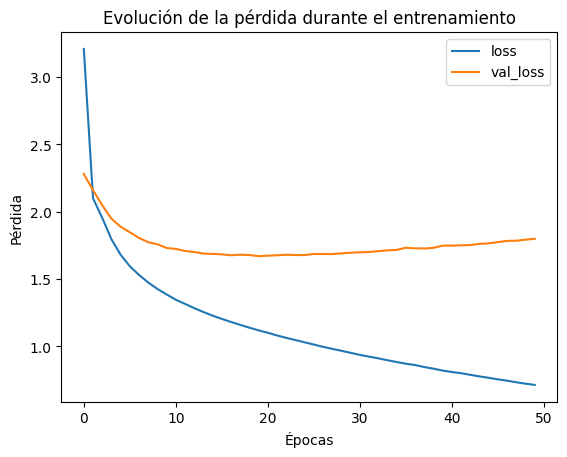

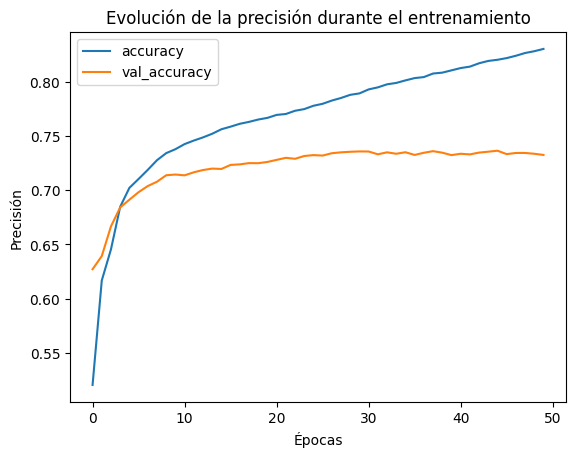

In [ ]:
# Graficamos la pérdida
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Evolución de la precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

Encoder para la inferencia

In [ ]:
# Modelo de inferencia del encoder
encoder_model_inference = Model(encoder_inputs, encoder_states)

Decoder para la inferencia

In [ ]:
# Estados del decoder como entradas
decoder_state_input_h = Input(shape=(256,), name='input_h')
decoder_state_input_c = Input(shape=(256,), name='input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Embedding del decoder
decoder_inputs_inference = Input(shape=(None,), name='decoder_input_inference')
decoder_embedding_inference = Embedding(input_dim=8000, output_dim=50)(decoder_inputs_inference)

# LSTM del decoder
decoder_outputs_inference, state_h_inference, state_c_inference = decoder_lstm(
    decoder_embedding_inference, initial_state=decoder_states_inputs)

# Densa del decoder
decoder_outputs_inference = decoder_dense(decoder_outputs_inference)

# Modelo de inferencia del decoder
decoder_model_inference = Model(
    [decoder_inputs_inference] + decoder_states_inputs,
    [decoder_outputs_inference, state_h_inference, state_c_inference])


In [ ]:
# Modelo de inferencia del encoder
encoder_model_inference = Model(encoder_inputs, encoder_states)

Función para predecir la secuencia

In [ ]:
idx2word_outputs = {v: k for k, v in word2idx_outputs.items()}

In [ ]:
print(word2idx_outputs)

{'eos': 1, 'sos': 2, 'you': 3, 'i': 4, 'do': 5, 'what': 6, 'a': 7, 'are': 8, 'to': 9, 'for': 10, 'how': 11, 'am': 12, 'living': 13, 'like': 14, 'love': 15, 'have': 16, 'is': 17, 'm': 18, 'your': 19, 'read': 20, 'hello': 21, 'oh': 22, 'good': 23, 'that': 24, 'hi': 25, 'it': 26, 'the': 27, 'any': 28, 'not': 29, 'yes': 30, 'u': 31, 'and': 32, 'work': 33, 'about': 34, 'me': 35, 's': 36, 'in': 37, 'no': 38, 'my': 39, 'ok': 40, 'fine': 41, 'from': 42, 'today': 43, 'of': 44, 'hobbies': 45, 'doing': 46, 't': 47, 'where': 48, 'name': 49, 'play': 50, 'too': 51, 'go': 52, 'so': 53, 'well': 54, 'see': 55, 'great': 56, 'don': 57, 'favorite': 58, 'bye': 59, 'pets': 60, 'nice': 61, 'know': 62, 'there': 63, 'at': 64, 'hey': 65, 'why': 66, 'can': 67, 'sure': 68, 'live': 69, 'cool': 70, 'fun': 71, 'thanks': 72, 'old': 73, 'games': 74, 'beach': 75, 'job': 76, 'tell': 77, 'with': 78, 'student': 79, 'mean': 80, 'sorry': 81, 'girl': 82, 'up': 83, 'video': 84, 'vegan': 85, 'day': 86, 'city': 87, 'nothing': 8

In [ ]:
# Cambio los índices de <sos> y <eos>
word2idx_outputs['<sos>'] = 1807  # Establecemos <sos> en 1807
word2idx_outputs['<eos>'] = 1808  # Establecemos <eos> en 1808

# Verificamos el diccionario después de los cambios
print("Diccionario después de cambios:", word2idx_outputs)

Diccionario después de cambios: {'eos': 1, 'sos': 2, 'you': 3, 'i': 4, 'do': 5, 'what': 6, 'a': 7, 'are': 8, 'to': 9, 'for': 10, 'how': 11, 'am': 12, 'living': 13, 'like': 14, 'love': 15, 'have': 16, 'is': 17, 'm': 18, 'your': 19, 'read': 20, 'hello': 21, 'oh': 22, 'good': 23, 'that': 24, 'hi': 25, 'it': 26, 'the': 27, 'any': 28, 'not': 29, 'yes': 30, 'u': 31, 'and': 32, 'work': 33, 'about': 34, 'me': 35, 's': 36, 'in': 37, 'no': 38, 'my': 39, 'ok': 40, 'fine': 41, 'from': 42, 'today': 43, 'of': 44, 'hobbies': 45, 'doing': 46, 't': 47, 'where': 48, 'name': 49, 'play': 50, 'too': 51, 'go': 52, 'so': 53, 'well': 54, 'see': 55, 'great': 56, 'don': 57, 'favorite': 58, 'bye': 59, 'pets': 60, 'nice': 61, 'know': 62, 'there': 63, 'at': 64, 'hey': 65, 'why': 66, 'can': 67, 'sure': 68, 'live': 69, 'cool': 70, 'fun': 71, 'thanks': 72, 'old': 73, 'games': 74, 'beach': 75, 'job': 76, 'tell': 77, 'with': 78, 'student': 79, 'mean': 80, 'sorry': 81, 'girl': 82, 'up': 83, 'video': 84, 'vegan': 85, 'da

In [ ]:
num_decoder_tokens = len(word2idx_outputs)
num_decoder_tokens

1808

In [ ]:
max_output_len = 10

# Función para decodificar la secuencia
def decode_sequence(input_seq):
    states_value = encoder_model_inference.predict(input_seq)

    print("Forma de states_value:", [s.shape for s in states_value])

    target_seq = np.zeros((1, 1))
    sos_index = word2idx_outputs.get('<sos>', None)
    if sos_index is not None:
        target_seq[0, 0] = sos_index
    else:
        print("Índice de <sos> no válido.")
        return "Error: Token <sos> no encontrado o fuera de rango."

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model_inference.predict([target_seq] + states_value)

        # Imprimir la salida intermedia
        #print("Output tokens:", output_tokens)

        # Introducir temperatura para suavizar la distribución
        temperature = 0.8
        output_tokens = output_tokens[0, -1, :]  # Solo la última predicción
        output_tokens = np.exp(output_tokens / temperature) / np.sum(np.exp(output_tokens / temperature))

        sampled_token_index = np.random.choice(len(output_tokens), p=output_tokens)
        sampled_word = idx2word_outputs.get(sampled_token_index, '')

        if sampled_word and sampled_word != '<sos>':
            if sampled_word == '<eos>':
                stop_condition = True
            else:
                decoded_sentence += ' ' + sampled_word

        if len(decoded_sentence.split()) >= max_output_len:
            stop_condition = True

        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

Pruebas

In [ ]:
# Preprocesamos la pregunta de prueba
test_input_sentence = "Do you read?"
test_input_seq = tokenizer_inputs.texts_to_sequences([test_input_sentence])
test_input_seq = pad_sequences(test_input_seq, maxlen=max_input_len, padding='post')

# Obtenemos la respuesta generada
decoded_sentence = decode_sequence(test_input_seq)

# Imprimimos la respuesta
print("Respuesta del chatbot:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Respuesta del chatbot: sports wrestler free mma chatting piano engineering harry eyou nooo


In [ ]:
# Preprocesamos la pregunta de prueba
test_input_sentence = "Do you have any pet?"
test_input_seq = tokenizer_inputs.texts_to_sequences([test_input_sentence])
test_input_seq = pad_sequences(test_input_seq, maxlen=max_input_len, padding='post')
# Obtenemos la respuesta generada
decoded_sentence = decode_sequence(test_input_seq)
# Imprimimos la respuesta
print("Respuesta del chatbot:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Forma de states_value: [(1, 256), (1, 256)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Respuesta del chatbot: fire month banking taste bodmas finish ping trauma bt gardening


In [ ]:
# Preprocesamos la pregunta de prueba
test_input_sentence = "Where are you from?"
test_input_seq = tokenizer_inputs.texts_to_sequences([test_input_sentence])
test_input_seq = pad_sequences(test_input_seq, maxlen=max_input_len, padding='post')
# Obtenemos la respuesta generada
decoded_sentence = decode_sequence(test_input_seq)
# Imprimimos la respuesta
print("Respuesta del chatbot:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Forma de states_value: [(1, 256), (1, 256)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Respuesta del chatbot: roads turing dick favorites fun man shopkeeper anything very it
